In [171]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [172]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [173]:
## create a toy dataset

X, y = make_blobs(n_samples=1000, centers=NUM_CLASSES, n_features=NUM_FEATURES, random_state=RANDOM_SEED,cluster_std=1.5)

X_blob=torch.from_numpy(X).float()
y_blob=torch.from_numpy(y).float()

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

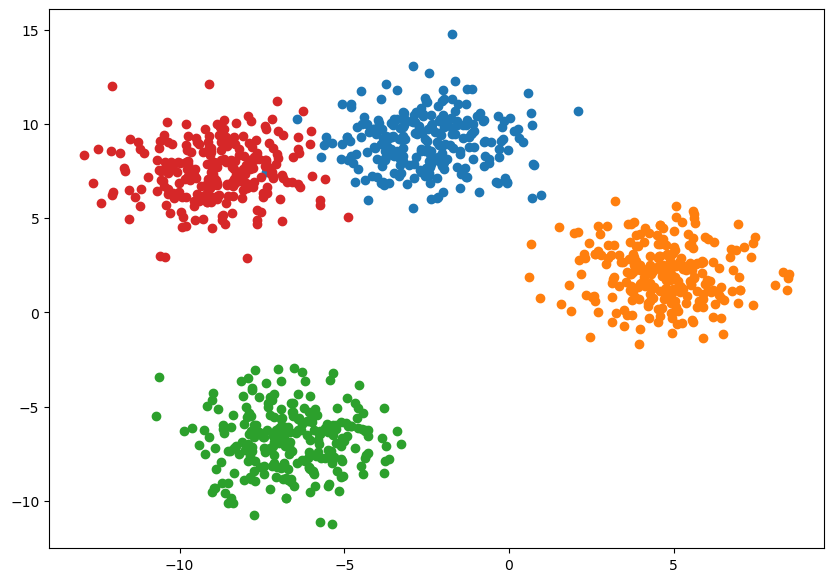

In [175]:
## Plot the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for i in range(NUM_CLASSES):
    plt.plot(X[y == i, 0], X[y == i, 1], 'o', label='class ' + str(i))
plt.show()


In [176]:
class BlobModel(nn.Module):
    """
    Initialize the model with 3 fully connected layers

    Parameters:
    in_features: int: Number of input features
    out_features: int: Number of output features
    bias: bool: If True, adds a learnable bias to the output
    device: str: Device to run the model on
    hidden_units: int: Number of hidden units in the model

    Returns:
    The model with 3 fully connected layers
    """
    def __init__(self,in_features:int=NUM_FEATURES, out_features:int=NUM_CLASSES,hidden_units:int=1000, bias:bool=True, device:str=device):
        super(BlobModel, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features, hidden_units, bias=bias),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units, bias=bias),
            nn.ReLU(),
            nn.Linear(hidden_units, out_features, bias=bias)
        )
        

    def forward(self, x):
        return self.linear_layer_stack(x)
    
    
    
    
        


In [177]:
model_blob = BlobModel().to(device)
print(model_blob)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=4, bias=True)
  )
)


In [204]:
loss=nn.CrossEntropyLoss()
optimizer = optim.Adam(model_blob.parameters(), lr=0.01)


def train(model, X_train, y_train, optimizer, loss, device, num_epochs=100):
    """
    Train the model

    Parameters:
    model: nn.Module: The model to train
    X_train: torch.Tensor: The training data
    y_train: torch.Tensor: The training labels
    optimizer: torch.optim: The optimizer to use
    loss: torch.nn: The loss function to use
    device: str: Device to run the model on
    num_epochs: int: Number of epochs to train the model

    Returns:
    model: nn.Module: The trained model
    """
    ## set tehe device on the datas
    
    X_train=X_train.to(device)
    y_train=y_train.to(device)
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss_value = loss(y_pred, y_train.long())
        loss_value.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, loss {loss_value.item()}')
    return model


In [205]:
trained_model = train(model_blob, X_train, y_train, optimizer, loss, device, num_epochs=1000)

Epoch 0, loss 0.008493443951010704
Epoch 10, loss 0.03696484863758087
Epoch 20, loss 0.01505137700587511
Epoch 30, loss 0.011403599753975868
Epoch 40, loss 0.011157645843923092
Epoch 50, loss 0.009896211326122284
Epoch 60, loss 0.009280149824917316
Epoch 70, loss 0.008879637345671654
Epoch 80, loss 0.008808741346001625
Epoch 90, loss 0.01009286381304264
Epoch 100, loss 0.008598089218139648
Epoch 110, loss 0.008140873163938522
Epoch 120, loss 0.008065895177423954
Epoch 130, loss 0.008081748150289059
Epoch 140, loss 0.007882045581936836
Epoch 150, loss 0.007983369752764702
Epoch 160, loss 0.00884130597114563
Epoch 170, loss 0.009431431069970131
Epoch 180, loss 0.009079894050955772
Epoch 190, loss 0.008283283561468124
Epoch 200, loss 0.00801650807261467
Epoch 210, loss 0.007783545181155205
Epoch 220, loss 0.007457813248038292
Epoch 230, loss 0.0072502996772527695
Epoch 240, loss 0.0073034013621509075
Epoch 250, loss 0.006985694169998169
Epoch 260, loss 0.013264870271086693
Epoch 270, loss

In [206]:
def predict(model, X_test):
    """
    Predict the output

    Parameters:
    model: nn.Module: The trained model
    X_test: torch.Tensor: The test data

    Returns:
    y_pred: torch.Tensor: The predicted output
    """
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
    return y_pred

def evaluate(y_test, y_pred):
    """
    Evaluate the model

    Parameters:
    y_test: torch.Tensor: The test labels
    y_pred: torch.Tensor: The predicted labels

    Returns:
    accuracy: float: The accuracy of the model
    """
    correct = 0
    total = 0
    predicted = torch.softmax(y_pred.data, 1)
    predicted=torch.argmax(predicted, dim=1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy



In [207]:
y_pred = predict(trained_model, X_test.to(device))

accuracy=evaluate(y_test.to(device), y_pred)

In [208]:
first_try=trained_model(X_test.to(device)[0:3])
first_try

tensor([[-314.9778,  478.9424, -151.0492, -436.0604],
        [ -24.0164,  -30.1551,  -51.6986,   23.1127],
        [-863.6403, -799.7230,  511.1441, -425.7626]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [209]:
torch.softmax(first_try, dim=1)


tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.4047e-21, 7.3460e-24, 3.2347e-33, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [210]:
accuracy

0.995